In [ ]:
# default_exp math

# math - Utility functions for calculations



In [ ]:
#export
import numpy
import scipy
import scipy.stats
import jax.numpy as jnp
import jax.scipy as jsc

In [ ]:
#hide
import hypothesis
from hypothesis import given
import hypothesis.strategies as st
import hypothesis.extra.numpy as hypo_numpy
from hypothesis import note
from numpy.testing import *

from matplotlib import pyplot

This is a collection of mathematical functions I sometimes find useful
***
## Numerically stable functions

In [ ]:
#export
def log1mexp(x, threshold=numpy.log(.5)):
    """Computes log(1 - exp(x))
    Note to self: Add citation"""
    #Some type handling
    if type(x) is not numpy.array:
        x=numpy.array(x)
    if hasattr(x, 'shape'):
        filter_val=x<threshold
        val=numpy.zeros(x.shape)
        #x<threshold
        val[filter_val]=numpy.log1p(-numpy.exp(x[filter_val]))
        #x>=threshold
        val[~filter_val]=numpy.log(- numpy.expm1(x[~filter_val]))
    else:
        if x<threshold:
            val=numpy.log1p(-numpy.exp(x))
        else:
            val=numpy.log( -numpy.expm1(x))
                        
        
    return val


In [ ]:
log1mexp(-2)

array(-0.14541346)

In [ ]:
#hide
@given(st.floats(min_value=-10,max_value=0))
def test_log1mexp_with_number(x):
    """Check to make sure the two approaches are consistent for numbers smaller than zero.
    Inputs should be less than zero, but not too small, because there will be some precision errors"""
    stable=log1mexp(x)
    standard=numpy.log(1-numpy.exp(x))
    note(f"{stable}=?={standard}")
    assert_almost_equal (stable,standard, err_msg="Calculations do not match"), 
test_log1mexp_with_number()

shape_strategy=hypo_numpy.array_shapes()
element_strategy=st.floats(min_value=-10, max_value=10)

@given(hypo_numpy.arrays(numpy.float,
                         elements=element_strategy,
                         shape=shape_strategy))
def test_log1mexp_with_array(x):
    """Check to make sure the two approaches are consistent for numbers smaller than zero.
    Inputs should be less than zero, but not too small, because there will be some precision errors"""
    stable=log1mexp(x)
    standard=numpy.log(1-numpy.exp(x))
    note(f"{stable}=?={standard}")
    assert_almost_equal (stable,standard, err_msg="Calculations do not match"), 
test_log1mexp_with_array()

/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


In [ ]:
#export
def logexpit(x):
    """Computes the log of the inverse logit function"""
    return -jnp.logaddexp(0, -x)

In [ ]:
print(numpy.log(scipy.special.expit(-100000)))
print(logexpit(-100000))

-inf
-100000.0


/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/mpm289/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [ ]:
#hide
@given(st.floats(min_value=-10,max_value=10))
def test_logexpit_with_number(x):
    """Check to make sure the two approaches are consistent for numbers smaller than zero.
    Inputs should be less than zero, but not too small, because there will be some precision errors"""
    stable=logexpit(x)
    standard=numpy.log(scipy.special.expit(x))
    note(f"{stable}=?={standard}")
    assert_almost_equal (stable,standard,5, err_msg="Calculations do not match"), 
test_logexpit_with_number()



## Transformations of functions

In some cases it maybe desirable to transform the output of a . This could be accomplished by modify the objective function itself, but for readability and flexibility I wrote a few wrapper functions. 

In [ ]:
#export
def arcsinh_transform(func):
    """A wrapper function that creates a new function with applies the signed pseudolog transfrom"""
    def call_func(*args, **kwargs):
        return numpy.arcsinh( func(*args,**kwargs)/2)
    return call_func

In [ ]:
#hide
def function_to_wrap(x):
    """Simple function to be used to test the arcsinh_transform wrapper"""
    return x

@given(st.floats(min_value=100), st.booleans())
def test_arcsinh_transform_with_bignumbers(x, positive):
    """Check to make sure this is almost sign(x)log(abs(x)) for big numbers"""
    sign=positive*2-1
    test_val=sign*x
    output=arcsinh_transform(function_to_wrap)(test_val)
    standard=numpy.sign(test_val)*numpy.log(numpy.abs(test_val))
    note(f"{output}=?={standard}")
    assert_almost_equal (output,standard,2, err_msg="Calculations do not approx match"), # 2 decimals should be good enough 
test_arcsinh_transform_with_bignumbers()

@given(st.floats(min_value=-.1, max_value=.1), st.booleans())
def test_arcsinh_transform_with_smallnumbers(x, positive):
    """Check to make sure this is almost x/2 for numbers near zero"""
    sign=positive*2-1
    test_val=sign*x
    output=arcsinh_transform(function_to_wrap)(test_val)
    standard=test_val/2
    note(f"{output}=?={standard}")
    assert_almost_equal (output,standard,2, err_msg="Calculations do not approx match"), # 2 decimals should be good enough 
test_arcsinh_transform_with_smallnumbers()

***
A common way to handle functions that vary across orders of magnitude is the log-transfr However, while the negative log-likelihood is often positive for many models, this will not necessarily be the case for all models. Probability density functions can return values greater than $1$ if the probability distribution is highly concentrated (for example, beta distributions do this frequently). In that case, the negative log-likelihood maybe negative, so a log-transformation cannot be applied to negative log-likelihoods in general.

An alternative in the inverse hyperbolic sine transformation (arcsineh): $asinh(\frac{x}{2})$. For large positives numbers, this is almost equivalent to the log-transform. For large negative numbers, this is almost equivalent to the negative of the log-transform. For smaller numbers, near zero, transformation is nearly linear and is almost equivalent to dividing them by $2$. That is, this transformation is always somewhere between a log-scale and linear-scale, being almost exactly log-scale for numbers with large magnitudes and almost exactly linear numbers near zero. Importantly, it's a monotonic transformation so it shouldn't change the location of optima, just squish the scales.

/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Text(0.5, 0, 'x')

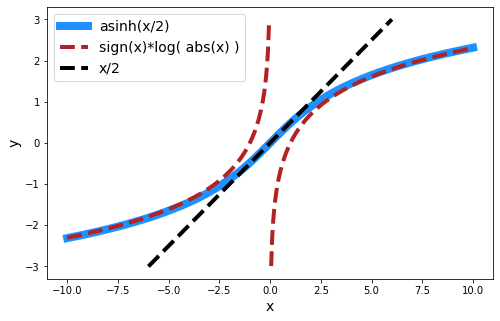

In [ ]:
pyplot.figure(figsize=(8,5))
x=numpy.hstack([numpy.linspace(-10,0,200),numpy.linspace(0,10,200)])
pyplot.plot(x,numpy.arcsinh(x/2), lw=8,c='dodgerblue', label='asinh(x/2)')
pyplot.plot(x, numpy.sign(x)*numpy.log(numpy.abs(x)), c='firebrick',ls='--', lw=4, label='sign(x)*log( abs(x) )')
pyplot.plot([-6,6],numpy.array([-6,6])/2,lw=4, ls='--',c='black', label='x/2')
pyplot.legend(fontsize=14)
pyplot.ylabel('y', size=14)
pyplot.xlabel('x',size=14)


In [ ]:
#export
def log_transform(func):
    """A wrapper function that creates a new function that applies the log transform"""
    def call_func(*args, **kwargs):
        return numpy.log( func(*args,**kwargs))
    return call_func